In [ ]:
# sam
!pip install git+https://github.com/facebookresearch/segment-anything.git

# for trransformers
!pip install -q git+https://github.com/huggingface/transformers.git

# to prepare datasets
!pip install datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qkims3l9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qkims3l9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=65cd983ecf33a94baa33747cfbc90eb9f78519c22309941245e2087c9110a83b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yrivmzmc/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install monai

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import SamProcessor
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

In [ ]:
from datasets import Dataset
from PIL import Image

# specify the paths to the images and masks folders
images_folder = "/content/Data/images"
masks_folder = "/content/Data/masks"

image_files = sorted(os.listdir(images_folder))

images = []
masks = []

for image_file in image_files:
    if image_file.endswith('.png'):
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, image_file)

        # loading image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        images.append(image)
        masks.append(mask)

dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

dataset = Dataset.from_dict(dataset_dict)

print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 1
})


Ensure, images and masks are loading properly

In [ ]:
print(len(images))

1


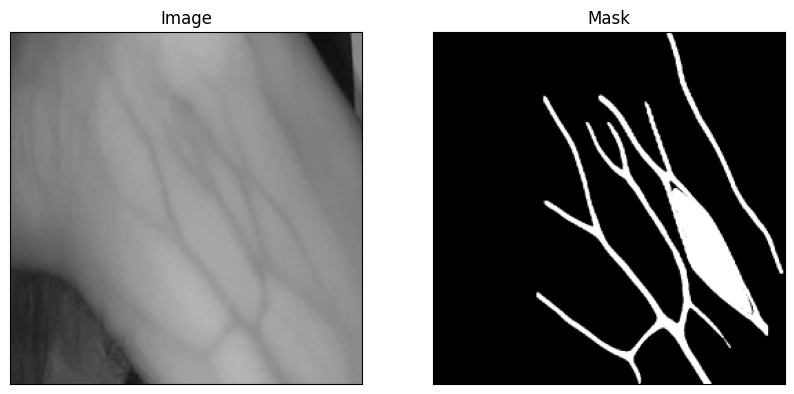

In [ ]:
img_num = random.randint(0, len(images)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
def draw_bounding_box(image, bbox, color=(255, 255, 255), thickness=2):
    """
    Draws a bounding box on the given image.

    Parameters:
    - image: The image on which to draw the bounding box.
    - bbox: The bounding box coordinates as a list [x_min, y_min, x_max, y_max].
    - color: The color of the bounding box (in BGR format).
    - thickness: The thickness of the bounding box lines.
    """
    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = bbox

    # Draw the bounding box on the image
    image_with_bbox = cv2.rectangle(image.copy(), (x_min, y_min), (x_max, y_max), color, thickness)

    return image_with_bbox

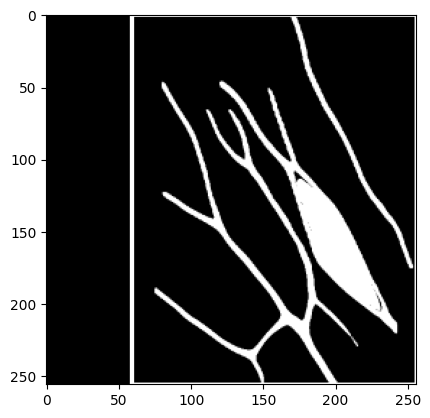

In [ ]:
mask = cv2.imread('/content/Data/masks/1.png', cv2.IMREAD_GRAYSCALE)
bbox = get_bounding_box(mask)
bbox_img = draw_bounding_box(mask, bbox)
plt.imshow(bbox_img, cmap='gray')

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 256, 256])


In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# computing gradients only for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
import torch.nn.functional as F
from torch.optim import Adam

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-3, weight_decay=0)
seg_loss = torch.nn.MSELoss(reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


EPOCH: 0
Mean loss: 6581.1513671875


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 1
Mean loss: 6173.0087890625


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 2
Mean loss: 6108.46142578125


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 3
Mean loss: 6069.86572265625


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 4
Mean loss: 6036.9697265625


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 5
Mean loss: 6006.03515625


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 6
Mean loss: 5973.720703125


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 7
Mean loss: 5933.86328125


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 8
Mean loss: 5888.0146484375


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

EPOCH: 9
Mean loss: 5825.40234375


In [ ]:
# save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")